# 1- Load Dataset

In [ ]:
import json

dataset = []

with open("activity_data.jsonl", "r", encoding="utf-8") as f:
  for line in f:
    if line.strip():
      dataset.append(json.loads(line))

print(len(dataset))
print(dataset[0].keys())

2000
dict_keys(['id', 'task_items', 'global_task_description'])


# 2- EDA

## EDA STRUCTURAL

### 1.1 Nombre de task_items par global_task

In [ ]:
import numpy as np

lens = [len(x["task_items"]) for x in dataset]

min(lens), max(lens), np.mean(lens), np.median(lens)

(3, 16, np.float64(9.028), np.float64(9.0))

In [ ]:
for line in dataset:
  if len(line["task_items"]) == 3:
    print(line)

{'id': '1536', 'task_items': ['"software_preferences.json, JSON, /home/user/config, Text editor, Configuration file for updating personal software preferences and settings', '"user_settings_backup.zip, ZIP, /home/user/backups, File manager, Backup of user settings before updating preferences', '"preferences_backup.bak, BAK, /home/user/backups, File manager, Backup file containing previous software settings for r_'], 'global_task_description': 'Update personal software preferences and settings'}


### 1.2 Longueur des task_items (tokens)\
* MiniLM a une limite contextuelle
* les commandes ultra-courtes sont ambiguës

À analyser :

min / max / moyenne

ratio :

< 4 tokens → trop vague
40 tokens → trop bruité

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def tok_len(t):
    return len(model.tokenizer.tokenize(t))

global_lengths = [
    sum(tok_len(t) for t in x["task_items"])
    for x in dataset
]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

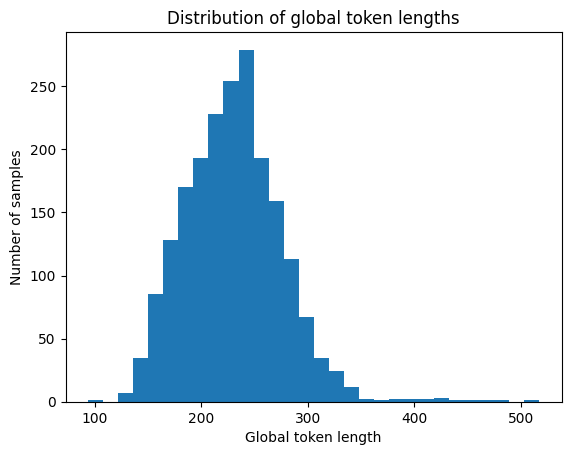

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(global_lengths, bins=30)
plt.xlabel("Global token length")
plt.ylabel("Number of samples")
plt.title("Distribution of global token lengths")
plt.show()


In [ ]:
import numpy as np

for p in [50, 75, 90, 95, 99]:
    print(f"{p}th percentile:", np.percentile(global_lengths, p))


50th percentile: 229.0
75th percentile: 258.0
90th percentile: 284.0
95th percentile: 303.0
99th percentile: 344.0


## EDA LEXICAL (BRUIT & VARIATION)

### 1 Vocabulaire global

* détecter tokens techniques dominants
* identifier tokens génériques (“used”, “opened”, “file”…)

In [ ]:
from collections import Counter

counter = Counter()
for x in dataset:
    for t in x["task_items"]:
        counter.update(t.lower().split())

counter.most_common(50)

[('and', 10060),
 ('to', 10055),
 ('for', 7407),
 ('the', 6195),
 ('used', 4510),
 ('with', 4080),
 ('a', 3889),
 ('in', 2960),
 ('file,', 2900),
 ('opened', 2850),
 ('text', 2608),
 ('of', 2484),
 ('application,', 2248),
 ('editor,', 2142),
 ('command,', 1803),
 ('on', 1600),
 ('file', 1583),
 ('network', 1572),
 ('configuration', 1564),
 ('data', 1398),
 ('application', 1209),
 ('browser,', 1189),
 ('web', 1149),
 ('system', 1092),
 ('performance', 1034),
 ('command', 1029),
 ('settings', 1012),
 ('contains', 992),
 ('logs', 921),
 ('log', 846),
 ('security', 830),
 ('model', 823),
 ('access', 803),
 ('stores', 796),
 ('from', 733),
 ('/scripts,', 712),
 ('terminal,', 684),
 ('provides', 664),
 ('across', 651),
 ('website,', 642),
 ('tool,', 586),
 ('defines', 586),
 ('monitor', 581),
 ('manage', 578),
 ('python', 572),
 ('api', 558),
 ('files', 548),
 ('status', 537),
 ('monitoring', 528),
 ('services', 509)]

### 2- Tokens trop fréquents (candidats stop-words)

In [ ]:
for tok, freq in counter.most_common(30):
    print(f"{tok:15s} {freq}")

and             10060
to              10055
for             7407
the             6195
used            4510
with            4080
a               3889
in              2960
file,           2900
opened          2850
text            2608
of              2484
application,    2248
editor,         2142
command,        1803
on              1600
file            1583
network         1572
configuration   1564
data            1398
application     1209
browser,        1189
web             1149
system          1092
performance     1034
command         1029
settings        1012
contains        992
logs            921
log             846


### 3- Diversité lexicale intra global_task

In [ ]:
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

In [ ]:
def lexical_diversity(tasks):
    tokens = []
    for t in tasks:
        tokens.extend(tokenize(t))
    return len(set(tokens)) / len(tokens) if tokens else 0

diversities = [
    lexical_diversity(x["task_items"])
    for x in dataset
]


In [ ]:
import numpy as np

np.min(diversities), np.mean(diversities), np.median(diversities), np.max(diversities)


(np.float64(0.3333333333333333),
 np.float64(0.5441238777061056),
 np.float64(0.5412246369348028),
 np.float64(0.75))

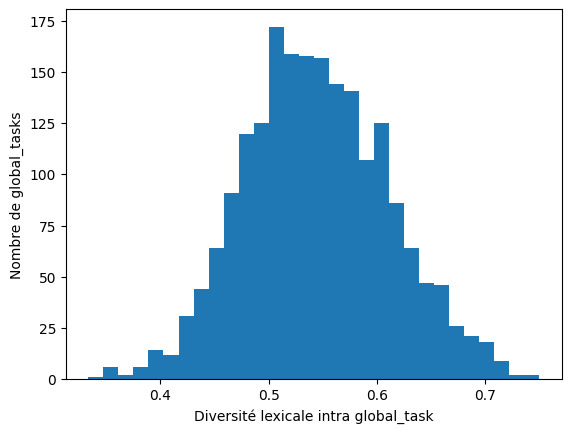

In [ ]:
import matplotlib.pyplot as plt

plt.hist(diversities, bins=30)
plt.xlabel("Diversité lexicale intra global_task")
plt.ylabel("Nombre de global_tasks")
plt.show()


## EDA SÉMANTIQUE (AVEC UN MODELE BRUT)

### 1 Similarité intra vs inter global_task

In [ ]:
from sentence_transformers import SentenceTransformer, util
import random

model = SentenceTransformer("all-MiniLM-L6-v2")

random.shuffle(dataset)

intra_sims = []
inter_sims = []

for x in dataset[:200]:
  tasks = x["task_items"]
  emb = model.encode(tasks)

  for i in range(len(emb)-1):
    intra_sims.append(util.cos_sim(emb[i], emb[i+1]).item())

for i in range(200):
  t1 = dataset[i]["task_items"][0]
  t2 = dataset[(i+1)%200]["task_items"][0]
  inter_sims.append(
      util.cos_sim(
          model.encode(t1),
          model.encode(t2)
      ).item()
  )

In [ ]:
import numpy as np

print("Moyenne intra :", np.mean(intra_sims))
print("Moyenne inter :", np.mean(inter_sims))

print("Std intra :", np.std(intra_sims))
print("Std inter :", np.std(inter_sims))


Moyenne intra : 0.5060002790031167
Moyenne inter : 0.19157822135370225
Std intra : 0.1532739396130872
Std inter : 0.11686875516254769


In [ ]:
print("Intra > Inter (%):",
      np.mean(np.array(intra_sims) > np.mean(inter_sims)) * 100)


Intra > Inter (%): 97.38124238733252


In [ ]:
overlap = np.mean(
    np.array(intra_sims) < np.percentile(inter_sims, 75)
)
print("Chevauchement estimé :", overlap)


Chevauchement estimé : 0.06942752740560293


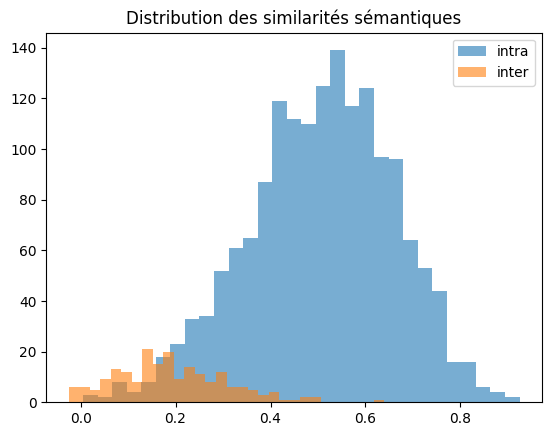

In [ ]:
import matplotlib.pyplot as plt

plt.hist(intra_sims, bins=30, alpha=0.6, label="intra")
plt.hist(inter_sims, bins=30, alpha=0.6, label="inter")
plt.legend()
plt.title("Distribution des similarités sémantiques")
plt.show()


### Global_task overlap

In [ ]:
global_embeddings = []
global_labels = []

for x in dataset[:200]:   # EDA → 200 suffit
    tasks = x["task_items"]
    emb = model.encode(tasks)

    # embedding du global_task = moyenne
    global_emb = np.mean(emb, axis=0)

    global_embeddings.append(global_emb)
    global_labels.append(x["global_task_description"])

### Calculer les similarités ENTRE global_tasks

In [ ]:
import torch

G = torch.tensor(global_embeddings)
sim_matrix = util.cos_sim(G, G)


/tmp/ipython-input-490317937.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  G = torch.tensor(global_embeddings)


### Extraire les paires dangereuses (cosine > 0.75)

In [ ]:
dangerous_pairs = []

threshold = 0.75

for i in range(len(global_labels)):
    for j in range(i+1, len(global_labels)):  # i != j
        score = sim_matrix[i][j].item()
        if score > threshold:
            dangerous_pairs.append(
                (global_labels[i], global_labels[j], score)
            )


### Inspecter concrètement (le plus important)

In [ ]:
# Trier par similarité décroissante
dangerous_pairs = sorted(dangerous_pairs, key=lambda x: -x[2])

for g1, g2, s in dangerous_pairs[:10]:
    print(f"{s:.3f} | {g1}  <-->  {g2}")


0.903 | Implement feature flags to manage feature rollouts safely  <-->  Implement feature flags to gradually release new features
0.893 | Validate network routing and interface configurations  <-->  Audit host network configurations for security gaps
0.889 | Debug and resolve memory leaks in production services  <-->  Monitor memory leak trends across critical applications
0.852 | Implement logging aggregation for multi-service applications  <-->  Set up log aggregation to centralize error and access logs
0.843 | Assess impact of network segmentation on application traffic  <-->  Assess network segmentation and traffic flow configurations for vulnerabilities
0.842 | Assess network segmentation and traffic flow configurations for vulnerabilities  <-->  Assess network segmentation effectiveness for security zones
0.835 | Test authentication mechanisms under authorization  <-->  Integrate authentication and authorization mechanisms securely
0.828 | Maintain VPN concentrators and remote a

# Structuration du dataset

## 1 Nettoyage minimal

In [ ]:
def normalize_task(text):
    """
    Nettoyage minimal d'un task_item ou global_task
    """
    # enlever les guillemets et les backslashes
    text = text.replace('\\"', '').replace('"', '')
    # passer en minuscules et strip
    text = text.lower().strip()
    return text


## Structuration à deux niveaux
Niveau A — petits tasks unitaires
→ Liste de task_items nettoyés

Niveau B — bloc global
→ Concaténation de tous les task_items de la ligne, forme un seul texte

In [ ]:
structured_dataset = []

for entry in dataset:
  task_items = entry["task_items"]

  # Niveau A : petits tasks unitaires
  small_tasks = [normalize_task(t) for t in task_items]

  # Niveau B : bloc global
  global_block = " ".join(small_tasks)

  # Ajouter au dataset structuré
  structured_dataset.append({
      "id": entry["id"],
      "small_tasks": small_tasks,
      "global_block": global_block,
      "global_task_description": normalize_task(entry["global_task_description"])
  })

In [ ]:
print(len(structured_dataset))
print(structured_dataset[0].keys())

# Exemple de premier élément
print(structured_dataset[0]["small_tasks"])
print(structured_dataset[0]["global_block"])
print(structured_dataset[0]["global_task_description"])


2000
dict_keys(['id', 'small_tasks', 'global_block', 'global_task_description'])
['index.html file in /var/www/project opened with visual studio code to structure the website content', 'style.css file in /var/www/project/css opened with sublime text to define responsive styles for desktop and mobile', 'app.js file in /var/www/project/js opened with webstorm to implement interactive website features', 'bootstrap application used to quickly design responsive layouts and components', 'google chrome application used to test website responsiveness across different screen sizes', 'firefox developer tools application used to inspect and debug css media queries', 'git init command to initialize a version control repository for the project', 'npm install command to add necessary frontend dependencies and frameworks', 'git commit -m command to save incremental changes in the website development', 'ping command to test server connectivity and responsiveness', 'curl command to check http responses

# Construction du dataset d’entraînement (CLÉ)

Le but : apprendre au modèle que chaque petit task appartient à son bloc global, et que les autres blocs servent de négatifs implicites grâce au MultipleNegativesRankingLoss.

### construction du dataset contrastif
- Pas besoin de générer de négatifs explicites

- Très stable pour grandes datasets

- Séparation fine des embeddings sémantiques

Cette loss va rapprocher le petit task et son global_block, et repousser automatiquement les autres blocs du batch.



In [ ]:
from sentence_transformers.losses import MultipleNegativesRankingLoss

### Création des exemples d’entraînement pour l’apprentissage de représentations sémantiques hiérarchiques

Les exemples d’entraînement sont construits de manière à apprendre des représentations sémantiques structurées autour d’une **tâche globale** et de ses **sous-tâches constitutives**, en exploitant la `MultipleNegativesRankingLoss` sans nécessiter de négatifs explicites.

#### 1. Absence de négatifs explicites et exploitation des négatifs implicites

La `MultipleNegativesRankingLoss` considère automatiquement les autres exemples du batch comme des négatifs implicites.
Ainsi, chaque paire positive est contrastée avec un grand nombre de paires non correspondantes, ce qui :

* simplifie la préparation des données,
* favorise une séparation sémantique efficace dans l’espace des embeddings,
* améliore la discrimination entre tâches globales distinctes.

L’efficacité de cette approche augmente avec la taille du batch, car le nombre de négatifs implicites croît proportionnellement.

---

#### 2. Apprentissage hiérarchique : sous-tâche → tâche globale

Pour chaque sous-tâche élémentaire (`small_task`), une paire positive est créée avec le bloc représentant la tâche globale (`global_block`).
Ce mécanisme apprend au modèle que :

* chaque sous-tâche est une composante sémantique du même objectif global,
* la tâche globale agit comme un **point d’attraction sémantique** dans l’espace des embeddings.

Cette relation renforce la structuration hiérarchique des représentations.

---

#### 3. Renforcement de la cohésion intra-cluster : sous-tâche ↔ sous-tâche

Des paires positives sont également générées entre toutes les sous-tâches appartenant à une même tâche globale.
Ce choix vise à :

* densifier localement l’espace embedding autour d’un même concept,
* renforcer la cohésion interne des sous-tâches,
* éviter que les sous-tâches ne soient reliées uniquement via le bloc global.

Ainsi, les sous-tâches forment un cluster compact et sémantiquement cohérent.

---

#### 4. Apprentissage compositionnel par augmentation de données

Une stratégie d’augmentation de données consiste à créer des sous-ensembles partiels de sous-tâches, concaténés en un seul texte, puis associés à la tâche globale.
Cette approche permet au modèle d’apprendre que :

* différentes combinaisons partielles de sous-tâches peuvent représenter le même objectif global,
* le sens de la tâche globale est invariant face à la suppression de certaines sous-composantes,
* la représentation est robuste aux variations et à l’incomplétude des informations.

---

#### 5. Effet global sur l’espace de représentation

La combinaison de ces trois types de paires positives (sous-tâche ↔ global, sous-tâche ↔ sous-tâche, sous-ensemble ↔ global), couplée aux négatifs implicites du batching, conduit à :

* une structuration hiérarchique claire de l’espace sémantique,
* des clusters centrés sur des tâches globales interprétables,
* une meilleure robustesse et stabilité des embeddings pour des tâches de regroupement orientées objectifs.

Cette stratégie est particulièrement adaptée aux scénarios où l’interprétabilité des clusters et leur correspondance avec des tâches globales sont prioritaires.


In [ ]:
from sentence_transformers import InputExample

train_examples = []

for obj in structured_dataset:
    small_tasks = obj["small_tasks"]   # déjà normalisés
    global_block = obj["global_block"]

    # 1️ POSITIFS : petit task ↔ bloc global
    for task in small_tasks:
        train_examples.append(
            InputExample(texts=[task, global_block])
        )

    # 2️ POSITIFS : task ↔ task (même global_task)
    for i in range(len(small_tasks)):
        for j in range(i + 1, len(small_tasks)):
            train_examples.append(
                InputExample(texts=[small_tasks[i], small_tasks[j]])
            )

    # 3️ POSITIFS : bloc ↔ sous-bloc (data augmentation)
    if len(small_tasks) > 1:
        subset = small_tasks[:int(len(small_tasks) * 0.7)]
        train_examples.append(
            InputExample(texts=[" ".join(subset), global_block])
        )

print(f"Nombre total d'exemples : {len(train_examples)}")


Nombre total d'exemples : 94790


In [ ]:
import os
import pickle

save_dir = "/content/drive/MyDrive/global_task_model"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "train_examples.pkl")

with open(save_path, "wb") as f:
    pickle.dump(train_examples, f)

print(f" train_examples sauvegardé dans {save_path}")


# Entraînement de l’encodeur

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
import math

In [ ]:
BASE_DIR = "/content/drive/MyDrive/global_task_model"

CHECKPOINT_DIR = f"{BASE_DIR}/checkpoints"
FINAL_MODEL_DIR = f"{BASE_DIR}/final_model"

import os
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)

### Define model

In [ ]:
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Create DataLoader

In [ ]:
train_batch_size = 8

train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=train_batch_size
)

### Define Loss

In [ ]:
train_loss = losses.MultipleNegativesRankingLoss(model)

### Définir le nombre d’epochs

In [ ]:
num_epochs = 3
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% warmup

### Lancer l’entraînement

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    show_progress_bar=True,
    checkpoint_path=CHECKPOINT_DIR,
    checkpoint_save_steps=2000,
    checkpoint_save_total_limit=3
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.317300
1000,0.171600
1500,0.133400
2000,0.133700
2500,0.134900
3000,0.118900
3500,0.100300


### Sauvegarder le modèle

In [ ]:
!ls /content/drive/MyDrive/global_task_model/checkpoints

checkpoint-10000  checkpoint-6000  checkpoint-8000  runs


In [ ]:
model.save(FINAL_MODEL_DIR)
print(f"Modèle sauvegardé dans : {FINAL_MODEL_DIR}")

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader
import pickle
import math

In [ ]:
import pickle

with open("/content/drive/MyDrive/global_task_model/train_examples.pkl", "rb") as f:
    train_examples = pickle.load(f)


In [ ]:
import torch
import random
import numpy as np

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
from torch.utils.data import DataLoader

train_batch_size = 8

train_dataloader = DataLoader(
    train_examples,
    shuffle=False,      # important pour reprise
    batch_size=train_batch_size
)


In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import losses

model = SentenceTransformer(
    "/content/drive/MyDrive/global_task_model/checkpoints/checkpoint-10000"
)

train_loss = losses.MultipleNegativesRankingLoss(model)

num_epochs = 3   #  souvent moins que la phase initiale
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    show_progress_bar=True,
    checkpoint_path="/content/drive/MyDrive/global_task_model/checkpoints",
    checkpoint_save_steps=2000,
    checkpoint_save_total_limit=3
)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
500,0.019600
1000,0.015800
1500,0.026000
2000,0.013400
2500,0.008300
3000,0.015300
3500,0.010600
4000,0.010300
4500,0.012700
5000,0.007200


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
final_path = "/content/drive/MyDrive/global_task_model/final_model"
model.save(final_path)

print(f" Modèle sauvegardé dans {final_path}")


In [ ]:
!ls /content/drive/MyDrive/global_task_model/final_model

1_Pooling			   README.md
2_Normalize			   sentence_bert_config.json
config.json			   special_tokens_map.json
config_sentence_transformers.json  tokenizer_config.json
model.safetensors		   tokenizer.json
modules.json			   vocab.txt


# EVALUATION

## Load the encoder model

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    "/content/drive/MyDrive/global_task_model/final_model"
)

model.eval()


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

### 1- Évaluation de la similarité intra-tâches pour chaque global_task

Cette fonction calcule la similarité cosinus entre toutes les petites tâches (small_tasks) d’une global_task donnée dans ton dataset structuré.

In [ ]:
import numpy as np
from sentence_transformers import util

def intra_global_similarity(model, structured_dataset):
    results = []

    for obj in structured_dataset:
        tasks = obj["small_tasks"]
        if len(tasks) < 2:
            continue

        emb = model.encode(tasks, convert_to_tensor=True)
        sims = util.cos_sim(emb, emb).cpu().numpy()

        # enlever diagonale
        values = sims[np.triu_indices(len(tasks), k=1)]

        results.append({
            "id": obj["id"],
            "mean": float(values.mean()),
            "min": float(values.min()),
            "max": float(values.max()),
            "std": float(values.std())
        })

    return results

## 2- Mesure de chevauchement sémantique entre deux global_tasks

Cette fonction calcule la similarité entre deux global_tasks différentes (obj_a et obj_b) afin de détecter d’éventuels chevauchements ou redondances.

In [ ]:
def inter_global_overlap(model, obj_a, obj_b):
    emb_a = model.encode(obj_a["small_tasks"], convert_to_tensor=True)
    emb_b = model.encode(obj_b["small_tasks"], convert_to_tensor=True)

    sims = util.cos_sim(emb_a, emb_b).cpu().numpy()
    return sims.mean(), sims.max()


## 3- Évaluation de la capacité de récupération (retrieval) des global_tasks

Cette fonction mesure à quel point le modèle peut associer correctement chaque petite tâche à son global_task parent dans le dataset. C’est une métrique de précision du modèle sur la structuration des tâches.

In [ ]:
def retrieval_accuracy(model, structured_dataset, k=1):
    global_blocks = [o["global_block"] for o in structured_dataset]
    global_ids = [o["id"] for o in structured_dataset]

    global_emb = model.encode(global_blocks, convert_to_tensor=True)

    correct = 0
    total = 0

    for obj in structured_dataset:
        for task in obj["small_tasks"]:
            q = model.encode(task, convert_to_tensor=True)
            sims = util.cos_sim(q, global_emb)[0]
            topk = sims.topk(k).indices.tolist()

            if global_ids.index(obj["id"]) in topk:
                correct += 1
            total += 1

    return correct / total


## 4- Comparaison des modèles SBERT pour la récupération des tâches

In [ ]:
from sentence_transformers import SentenceTransformer

base = SentenceTransformer("all-MiniLM-L6-v2")

acc_base = retrieval_accuracy(base, structured_dataset)
acc_finetuned = retrieval_accuracy(model, structured_dataset)

print("Base:", acc_base)
print("Fine-tuned:", acc_finetuned)


Base: 0.6356889676561808
Fine-tuned: 0.8803167922020381


In [ ]:
from itertools import combinations


# -----------------------------
#  Calcul et affichage des mesures
# -----------------------------
# Intra-global similarity
intra_results = intra_global_similarity(model, structured_dataset)
print(" Intra-global similarity:")
for r in intra_results:
    print(f"ID {r['id']}: mean={r['mean']:.3f}, min={r['min']:.3f}, max={r['max']:.3f}, std={r['std']:.3f}")

# Inter-global overlap
print("\n Inter-global overlap:")
for obj_a, obj_b in combinations(structured_dataset, 2):
    mean_sim, max_sim = inter_global_overlap(model, obj_a, obj_b)
    print(f"{obj_a['id']} vs {obj_b['id']}: mean={mean_sim:.3f}, max={max_sim:.3f}")

# Retrieval accuracy
acc = retrieval_accuracy(model, structured_dataset)
print(f"\n Retrieval accuracy: {acc:.3f}")

Streaming output truncated to the last 5000 lines.
ID 265: mean=0.710, min=0.569, max=0.869, std=0.073
ID 266: mean=0.767, min=0.530, max=0.937, std=0.106
ID 267: mean=0.792, min=0.582, max=0.928, std=0.085
ID 268: mean=0.797, min=0.602, max=0.938, std=0.103
ID 269: mean=0.771, min=0.585, max=0.870, std=0.062
ID 270: mean=0.705, min=0.476, max=0.949, std=0.137
ID 271: mean=0.695, min=0.553, max=0.909, std=0.097
ID 272: mean=0.686, min=0.516, max=0.858, std=0.088
ID 273: mean=0.724, min=0.579, max=0.880, std=0.093
ID 274: mean=0.799, min=0.700, max=0.897, std=0.064
ID 275: mean=0.628, min=0.402, max=0.854, std=0.108
ID 276: mean=0.755, min=0.580, max=0.848, std=0.074
ID 277: mean=0.821, min=0.658, max=0.927, std=0.076
ID 278: mean=0.683, min=0.494, max=0.873, std=0.120
ID 279: mean=0.681, min=0.532, max=0.879, std=0.103
ID 280: mean=0.870, min=0.757, max=0.958, std=0.050
ID 281: mean=0.789, min=0.643, max=0.940, std=0.081
ID 282: mean=0.799, min=0.671, max=0.918, std=0.057
ID 283: mean=

KeyboardInterrupt: 

# INFERENCE

- Lors de l’inférence, le processus de clustering sémantique est réalisé en plusieurs étapes successives afin d’obtenir des groupes cohérents, interprétables et robustes.

- À partir des embeddings normalisés des tâches, une première segmentation globale est effectuée par clustering hiérarchique agglomératif.

- Cette segmentation est ensuite raffinée par un mécanisme de reclustering itératif basé sur la cohésion interne des clusters. Les éléments isolés (singletons) sont traités séparément afin d’éviter une fragmentation excessive.

- Enfin, un dernier passage de reclustering adaptatif est appliqué aux clusters trop hétérogènes afin d’assurer que chaque cluster final représente une tâche globale cohérente, potentiellement composée de sous-tâches connexes.

In [ ]:
tasks = [
    "steam, application, launched Steam and logged in",
    "steam://rungameid/570, URL, Steam, launched Dota 2 via Steam game ID",
    "dota2.log, LOG file, /home/user/.steam/steam/logs, Cat, reviewed Dota 2 launch logs",
    "dota2_screenshots.zip, ZIP file, /home/user/Videos/Dota2, Archive Manager, compressed game screenshots",
    "dota2_match_2026-01-18.dem, DEM replay file, /home/user/Videos/Dota2/Replays, Game client, watched match replay",

    "steam://rungameid/730, URL, Steam, launched CS:GO",
    "csgo_config.cfg, CFG file, /home/user/.steam/steam/steamapps/common/Counter-Strike Global Offensive/csgo/cfg, VS Code, edited game settings (crosshair, sensitivity)",
    "obs, application, started recording CS:GO gameplay",
    "obs_recording_01.mkv, MKV file, /home/user/Videos/CSGO, VLC, played recorded gameplay",

    "lutris, application, launched a Windows game through Wine",
    "winecfg, command, configured Wine settings for game compatibility",
    "protontricks, command, applied compatibility fixes to Steam game",

    "steam_screenshot_001.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot",
    "steam_screenshot_002.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot",
    "game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update",

    "discord, application, joined a gaming voice channel",
    "discord_chat_log.txt, TXT file, /home/user/Documents/DiscordLogs, Gedit, read chat messages",
    "twitch.tv, web page, Firefox, watched a live gaming stream",
    "https://store.steampowered.com/app/570/Dota_2/, web page, Firefox, checked Dota 2 store page"
]


In [ ]:
# def normalize_task(text):
#     """
#     Nettoyage minimal d'un task_item ou global_task
#     """
#     # enlever les guillemets et les backslashes
#     text = text.replace('\\"', '').replace('"', '')
#     # passer en minuscules et strip
#     text = text.lower().strip()
#     return text


## Shuffle

In [ ]:
import random

random.seed(42)
random.shuffle(tasks)


In [ ]:
for t in tasks:
  print(t)

game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update
steam_screenshot_002.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
dota2_match_2026-01-18.dem, DEM replay file, /home/user/Videos/Dota2/Replays, Game client, watched match replay
lutris, application, launched a Windows game through Wine
steam://rungameid/730, URL, Steam, launched CS:GO
discord, application, joined a gaming voice channel
twitch.tv, web page, Firefox, watched a live gaming stream
csgo_config.cfg, CFG file, /home/user/.steam/steam/steamapps/common/Counter-Strike Global Offensive/csgo/cfg, VS Code, edited game settings (crosshair, sensitivity)
steam_screenshot_001.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
discord_chat_log.txt, TXT file, /home/user/Documents/DiscordLogs, Gedit, read chat messages
winecfg, command, configured Wine settings for game compatibility
steam:

## Encoder les tâches

In [ ]:
from sentence_transformers import util

embeddings = model.encode(
    tasks,
    convert_to_tensor=True,
    normalize_embeddings=True
)


## Construire la distance cosinus

In [ ]:
import numpy as np

sim = util.cos_sim(embeddings, embeddings).cpu().numpy()
dist = 1 - sim
dist = np.clip(dist, 0, None)  # CRUCIAL (corrige l’erreur silhouette)


# Step 1 — Clustering global initial par similarité sémantique

- structuration globale

- détection automatique du nombre de clusters

- base stable pour les étapes suivantes

## Fonctions d’évaluation

In [ ]:
from sklearn.metrics import silhouette_score
from collections import defaultdict

def cluster_cohesion(dist, labels):
    clusters = defaultdict(list)
    for i, c in enumerate(labels):
        clusters[c].append(i)

    cohesions = {}
    for c, idxs in clusters.items():
        if len(idxs) < 2:
            cohesions[c] = 0.0
            continue
        sub = dist[np.ix_(idxs, idxs)]
        cohesions[c] = sub.mean()

    return cohesions


## Clustering hiérarchique

In [ ]:
from sklearn.cluster import AgglomerativeClustering

thresholds = np.arange(0.45, 0.85, 0.01)

best = {
    "th": None,
    "silhouette": -1,
    "labels": None,
    "cohesion": None
}

for th in thresholds:
    clustering = AgglomerativeClustering(
        n_clusters=None,
        metric="precomputed",
        linkage="average",
        distance_threshold=th
    )

    labels = clustering.fit_predict(dist)
    n_clusters = len(set(labels))

    # Rejets intelligents
    if n_clusters <= 1 or n_clusters > len(tasks) // 2:
        continue

    sil = silhouette_score(dist, labels, metric="precomputed")
    cohesion = cluster_cohesion(dist, labels)

    if sil > best["silhouette"]:
        best.update({
            "th": th,
            "silhouette": sil,
            "labels": labels,
            "cohesion": cohesion
        })


In [ ]:
print(f"Meilleur threshold : {best['th']:.3f}")
print(f"Silhouette score : {best['silhouette']:.3f}")
print(f"Clusters détectés : {len(set(best['labels']))}")


Meilleur threshold : 0.730
Silhouette score : 0.278
Clusters détectés : 2


## Afficher les clusters

In [ ]:
from collections import defaultdict

groups = defaultdict(list)
for task, cid in zip(tasks, best["labels"]):
    groups[cid].append(task)

for cid, ts in groups.items():
    print(f"\nCluster {cid}")
    for t in ts:
        print(" -", t)



Cluster 0
 - game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update
 - steam_screenshot_002.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - dota2_match_2026-01-18.dem, DEM replay file, /home/user/Videos/Dota2/Replays, Game client, watched match replay
 - lutris, application, launched a Windows game through Wine
 - steam://rungameid/730, URL, Steam, launched CS:GO
 - discord, application, joined a gaming voice channel
 - twitch.tv, web page, Firefox, watched a live gaming stream
 - csgo_config.cfg, CFG file, /home/user/.steam/steam/steamapps/common/Counter-Strike Global Offensive/csgo/cfg, VS Code, edited game settings (crosshair, sensitivity)
 - steam_screenshot_001.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - winecfg, command, configured Wine settings for game compatibility
 - steam://rungameid/570, URL, Steam, launched Dota 2 via

## Évaluer le clustering

### Cohésion intra-cluster

In [ ]:
print("\n=== Cohésion par cluster ===")

cluster_cohesions = []

for c, items in groups.items():
    idxs = [tasks.index(t) for t in items]

    # on ignore les singletons
    if len(idxs) > 1:
        d = dist[np.ix_(idxs, idxs)]
        cohesion = d[np.triu_indices_from(d, 1)].mean()
        cluster_cohesions.append(cohesion)
        print(f"Cluster {c} | cohésion = {cohesion:.3f}")

#Moyenne des cohésions (clusters de taille ≥ 2 uniquement)
mean_cohesion = np.mean(cluster_cohesions) if cluster_cohesions else 0.0

print("\n=== Cohésion moyenne (clusters ≥ 2) ===")
print(f"Cohésion moyenne = {mean_cohesion:.3f}")



=== Cohésion par cluster ===
Cluster 0 | cohésion = 0.635

=== Cohésion moyenne (clusters ≥ 2) ===
Cohésion moyenne = 0.635


# Step 2 — Reclustering itératif basé sur la cohésion interne

- éliminer les clusters trop larges

- affiner localement la structure

- préserver les singletons significatifs

### Fonction pour recluster un sous-ensemble de tâches

In [ ]:
def recluster_subset(tasks_subset, dist_matrix_subset, thresholds=np.arange(0.45, 0.85, 0.01)):
    n = len(tasks_subset)

    # Cas 1 élément → impossible à diviser
    if n < 2:
        return {0: tasks_subset}, None, 0.0

    # Cas EXACTEMENT 2 éléments → division forcée
    if n == 2:
        return {0: [tasks_subset[0]], 1: [tasks_subset[1]]}, None, 0.0

    # Cas EXACTEMENT 3 éléments → division forcée en 2 clusters (2+1)
    if n == 3:
        return {0: [tasks_subset[0], tasks_subset[1]], 1: [tasks_subset[2]]}, None, 0.0

    # Cas général n >= 4
    results = {2: {"sil": -1, "th": None, "labels": None},
               3: {"sil": -1, "th": None, "labels": None}}

    for th in thresholds:
        clustering = AgglomerativeClustering(
            n_clusters=None,
            metric="precomputed",
            linkage="average",
            distance_threshold=th
        )
        labels = clustering.fit_predict(dist_matrix_subset)
        n_clusters = len(set(labels))
        if n_clusters not in (2,3):
            continue
        try:
            sil = silhouette_score(dist_matrix_subset, labels, metric="precomputed")
        except ValueError:
            sil = 0.0
        if sil > results[n_clusters]["sil"] or (np.isclose(sil, results[n_clusters]["sil"]) and (results[n_clusters]["th"] is None or th > results[n_clusters]["th"])):
            results[n_clusters].update({"sil": sil, "th": th, "labels": labels})

    # Choisir 3 clusters si silhouette >= 2 clusters
    chosen_k = 3 if results[3]["sil"] >= results[2]["sil"] else 2
    chosen = results[chosen_k]

    if chosen["labels"] is None:
        # Si aucun résultat, forcer division 2 clusters (cas par défaut)
        return {0: tasks_subset[:n//2], 1: tasks_subset[n//2:]}, None, 0.0

    new_groups = defaultdict(list)
    for i, lbl in enumerate(chosen["labels"]):
        new_groups[lbl].append(tasks_subset[i])
    return new_groups, chosen["th"], chosen["sil"]


### Pipeline principal avec reclustering conditionnel

In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.cluster import AgglomerativeClustering

best_threshold_global = best["th"]

clustering = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    linkage="average",
    distance_threshold=best_threshold_global
)
labels = clustering.fit_predict(dist)
n_clusters = len(set(labels))
print("th:", th, "n_clusters:", n_clusters, "labels:", labels)

groups = defaultdict(list)
for task, lbl in zip(tasks, labels):
    groups[lbl].append(task)

COHESION_THRESHOLD = 0.39
final_groups = {}
new_label_counter = 0

clusters_to_check = list(groups.values())

while clusters_to_check:
    current = clusters_to_check.pop(0)
    n = len(current)

    # Cas 1 élément → terminal
    if n < 2:
        final_groups[new_label_counter] = current
        new_label_counter += 1
        continue

    idxs = [tasks.index(t) for t in current]
    sub_dist = dist[np.ix_(idxs, idxs)]
    mean_cohesion = sub_dist[np.triu_indices_from(sub_dist, 1)].mean()

    if mean_cohesion > COHESION_THRESHOLD:
        new_sub_groups, sub_th, sub_sil = recluster_subset(current, sub_dist)

        # Si aucune vraie division
        if len(new_sub_groups) == 1:
            final_groups[new_label_counter] = current
            new_label_counter += 1
        else:
            for sub_items in new_sub_groups.values():
                clusters_to_check.append(sub_items)
    else:
        final_groups[new_label_counter] = current
        new_label_counter += 1


th: 0.8400000000000003 n_clusters: 2 labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [ ]:
# --- Affichage final des clusters après reclustering itératif ---
print("\n=== Clusters finaux après reclustering itératif ===")
for c, items in final_groups.items():
    print(f"\nCluster {c} | {len(items)} tâches")
    for t in items:
        print(" -", t)



=== Clusters finaux après reclustering itératif ===

Cluster 0 | 1 tâches
 - discord_chat_log.txt, TXT file, /home/user/Documents/DiscordLogs, Gedit, read chat messages

Cluster 1 | 1 tâches
 - steam, application, launched Steam and logged in

Cluster 2 | 1 tâches
 - game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update

Cluster 3 | 4 tâches
 - steam_screenshot_002.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - csgo_config.cfg, CFG file, /home/user/.steam/steam/steamapps/common/Counter-Strike Global Offensive/csgo/cfg, VS Code, edited game settings (crosshair, sensitivity)
 - steam_screenshot_001.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - dota2_screenshots.zip, ZIP file, /home/user/Videos/Dota2, Archive Manager, compressed game screenshots

Cluster 4 | 2 tâches
 - dota2.log, LOG file, /home/user/.steam/steam/logs, Cat, reviewed

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Construire les labels finaux pour silhouette
final_labels = np.zeros(len(tasks), dtype=int)
for c, items in final_groups.items():
    for t in items:
        idx = tasks.index(t)
        final_labels[idx] = c

sil_final = silhouette_score(dist, final_labels, metric="precomputed")
print("Silhouette score final après reclustering:", round(sil_final, 3))


Silhouette score final après reclustering: 0.161


In [ ]:
print("\n=== Cohésion finale par cluster ===")

final_cluster_cohesions = []

for c, items in final_groups.items():
    idxs = [tasks.index(t) for t in items]

    if len(idxs) < 2:
        mean_d = 0.0
    else:
        d = dist[np.ix_(idxs, idxs)]
        mean_d = d[np.triu_indices_from(d, 1)].mean()
        final_cluster_cohesions.append(mean_d)

    print(f"Cluster {c} | cohésion = {mean_d:.3f}")

# Moyenne des cohésions (clusters de taille ≥ 2 uniquement)
mean_final_cohesion = (
    np.mean(final_cluster_cohesions)
    if final_cluster_cohesions else 0.0
)

print("\n=== Cohésion moyenne finale (clusters ≥ 2) ===")
print(f"Cohésion moyenne finale = {mean_final_cohesion:.3f}")



=== Cohésion finale par cluster ===
Cluster 0 | cohésion = 0.000
Cluster 1 | cohésion = 0.000
Cluster 2 | cohésion = 0.000
Cluster 3 | cohésion = 0.310
Cluster 4 | cohésion = 0.383
Cluster 5 | cohésion = 0.000
Cluster 6 | cohésion = 0.369
Cluster 7 | cohésion = 0.000
Cluster 8 | cohésion = 0.334
Cluster 9 | cohésion = 0.000
Cluster 10 | cohésion = 0.000

=== Cohésion moyenne finale (clusters ≥ 2) ===
Cohésion moyenne finale = 0.349


# Step 3 — Gestion explicite des singletons et reclustering ciblé

- éviter la sur-fragmentation

- préserver les tâches réellement indépendantes

- détecter des regroupements faibles mais pertinents

## Extraire les singletons

In [ ]:
# --- Extraction des singletons ---
singletons = []
non_singleton_groups = {}

for cid, items in final_groups.items():
    if len(items) == 1:
        singletons.append(items[0])
    else:
        non_singleton_groups[cid] = items

print(f"{len(singletons)} singletons extraits sur {len(tasks)} tâches")


7 singletons extraits sur 19 tâches


## Condition de proportion

In [ ]:
SINGLETON_RATIO_THRESHOLD = 0.2

if len(singletons) / len(tasks) < SINGLETON_RATIO_THRESHOLD:
    print("Pas assez de singletons → pas de reclustering global")
    new_tasks = []
else:
    new_tasks = singletons
    print("Reclustering global des singletons activé")


Reclustering global des singletons activé


## Reclustering NORMAL appliqué à new_tasks

In [ ]:
from sentence_transformers import util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from collections import defaultdict
import numpy as np

if new_tasks:
    # Embeddings
    new_embeddings = model.encode(
        new_tasks,
        convert_to_tensor=True,
        normalize_embeddings=True
    )

    new_sim = util.cos_sim(new_embeddings, new_embeddings).cpu().numpy()
    new_dist = 1 - new_sim
    new_dist = np.clip(new_dist, 0, None)

    # Recherche du meilleur threshold
    best_singleton = {
        "th": None,
        "silhouette": -1,
        "labels": None
    }

    for th in thresholds:
        clustering = AgglomerativeClustering(
            n_clusters=None,
            metric="precomputed",
            linkage="average",
            distance_threshold=th
        )

        labels = clustering.fit_predict(new_dist)
        n_clusters = len(set(labels))


        if n_clusters <= 1 or n_clusters > len(new_tasks) // 2:
            continue

        sil = silhouette_score(new_dist, labels, metric="precomputed")

        if sil > best_singleton["silhouette"]:
            best_singleton.update({
                "th": th,
                "silhouette": sil,
                "labels": labels
            })

    # Construction des nouveaux clusters issus des singletons
    singleton_clusters = defaultdict(list)

    singleton_clusters = defaultdict(list)

    if best_singleton["labels"] is None:
        # Aucun reclustering valide → on garde les singletons tels quels
        for t in new_tasks:
            singleton_clusters[len(singleton_clusters)] = [t]
    else:
        for task, lbl in zip(new_tasks, best_singleton["labels"]):
            singleton_clusters[lbl].append(task)
else:
    singleton_clusters = {}


## Fusion finale

In [ ]:
# --- Fusion finale ---
final_merged_groups = {}
cid = 0

# Clusters non-singletons
for items in non_singleton_groups.values():
    final_merged_groups[cid] = items
    cid += 1

# Nouveaux clusters issus des singletons
for items in singleton_clusters.values():
    final_merged_groups[cid] = items
    cid += 1


In [ ]:
print("\n=== Clusters finaux après reclustering des singletons ===")
for c, items in final_merged_groups.items():
    print(f"\nCluster {c} | {len(items)} tâches")
    for t in items:
        print(" -", t)



=== Clusters finaux après reclustering des singletons ===

Cluster 0 | 4 tâches
 - steam_screenshot_002.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - csgo_config.cfg, CFG file, /home/user/.steam/steam/steamapps/common/Counter-Strike Global Offensive/csgo/cfg, VS Code, edited game settings (crosshair, sensitivity)
 - steam_screenshot_001.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - dota2_screenshots.zip, ZIP file, /home/user/Videos/Dota2, Archive Manager, compressed game screenshots

Cluster 1 | 2 tâches
 - dota2.log, LOG file, /home/user/.steam/steam/logs, Cat, reviewed Dota 2 launch logs
 - https://store.steampowered.com/app/570/Dota_2/, web page, Firefox, checked Dota 2 store page

Cluster 2 | 3 tâches
 - lutris, application, launched a Windows game through Wine
 - winecfg, command, configured Wine settings for game compatibility
 - protontricks, command, applied 

In [ ]:
# --- Reconstruction des labels finaux ---
task_to_index = {t: i for i, t in enumerate(tasks)}

labels_final = np.full(len(tasks), -1, dtype=int)

for cid, items in final_merged_groups.items():
    for t in items:
        labels_final[task_to_index[t]] = cid

# Sécurité
assert np.all(labels_final != -1)


In [ ]:
from sklearn.metrics import silhouette_score

# Compter les clusters non-singletons
cluster_sizes = {}
for cid in labels_final:
    cluster_sizes[cid] = cluster_sizes.get(cid, 0) + 1

valid_clusters = [cid for cid, sz in cluster_sizes.items() if sz >= 2]

if len(valid_clusters) >= 2:
    sil_final = silhouette_score(dist, labels_final, metric="precomputed")
else:
    sil_final = None

print("Silhouette finale :", sil_final)


Silhouette finale : 0.14388137


In [ ]:
from collections import defaultdict

def cluster_cohesion(dist, labels):
    clusters = defaultdict(list)
    for i, c in enumerate(labels):
        clusters[c].append(i)

    cohesions = {}
    for c, idxs in clusters.items():
        if len(idxs) < 2:
            cohesions[c] = 0.0
            continue
        sub = dist[np.ix_(idxs, idxs)]
        cohesions[c] = sub[np.triu_indices_from(sub, 1)].mean()

    return cohesions


cohesions_final = cluster_cohesion(dist, labels_final)

print("\nCohésion par cluster :")
for cid, coh in cohesions_final.items():
    print(f"Cluster {cid} | cohésion = {coh:.3f}")

# Cohésion moyenne (clusters >= 2)
valid_cohesions = [c for cid, c in cohesions_final.items()
                   if sum(labels_final == cid) >= 2]

mean_cohesion_final = np.mean(valid_cohesions) if valid_cohesions else None

print("\nCohésion moyenne finale :", mean_cohesion_final)



Cohésion par cluster :
Cluster 5 | cohésion = 0.724
Cluster 0 | cohésion = 0.310
Cluster 2 | cohésion = 0.369
Cluster 3 | cohésion = 0.334
Cluster 4 | cohésion = 0.000
Cluster 1 | cohésion = 0.383

Cohésion moyenne finale : 0.42416897


# Step 4 — Reclustering adaptatif final des clusters hétérogènes

- correction finale des clusters trop larges

- contrôle fin de la granularité

- alignement avec des tâches globales interprétables

In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.cluster import AgglomerativeClustering

COHESION_THRESHOLD = 0.65

## COmputer cohesion

In [ ]:
def compute_cohesion(sub_dist):
    n = sub_dist.shape[0]
    if n < 2:
        return 0.0
    return sub_dist[np.triu_indices_from(sub_dist, 1)].mean()


In [ ]:
def best_split_by_k(tasks_subset, dist_matrix_subset):
    n = len(tasks_subset)

    for k in range(2, n + 1):
        clustering = AgglomerativeClustering(
            n_clusters=k,
            metric="precomputed",
            linkage="average"
        )
        labels = clustering.fit_predict(dist_matrix_subset)

        total_cohesion = 0.0
        for lbl in set(labels):
            idxs = np.where(labels == lbl)[0]
            sub_d = dist_matrix_subset[np.ix_(idxs, idxs)]
            total_cohesion += compute_cohesion(sub_d)

        avg_cohesion = total_cohesion / k

        print(f"  -> k={k} | avg_cohesion={avg_cohesion:.3f}")

        # VALIDATION : on accepte le premier k qui passe le seuil
        if avg_cohesion <= 0.5:
            print(f"  => split VALIDÉ: k={k} | avg_cohesion={avg_cohesion:.3f}\n")
            return {
                "k": k,
                "labels": labels,
                "avg_cohesion": avg_cohesion
            }

    # si aucun k n'est valide
    print("  => aucun split valide (avg_cohesion > 0.5 pour tous les k)\n")
    return {"k": None, "labels": None, "avg_cohesion": None}


## calculer les clusters à partir de labels_final

In [ ]:
from collections import defaultdict

# reconstruction clusters depuis labels_final
clusters_from_labels = defaultdict(list)
for idx, c in enumerate(labels_final):
    clusters_from_labels[c].append(tasks[idx])


## sélectionner les clusters à reclusteriser (cohésion > 0.7)

In [ ]:
clusters_to_recluster = []
clusters_kept = {}

for cid, items in clusters_from_labels.items():
    idxs = [tasks.index(t) for t in items]
    if len(idxs) < 2:
        clusters_kept[cid] = items
        continue
    sub_dist = dist[np.ix_(idxs, idxs)]
    coh = compute_cohesion(sub_dist)

    if coh > COHESION_THRESHOLD:  # 0.7
        clusters_to_recluster.append((cid, items))
    else:
        clusters_kept[cid] = items


## reclusteriser les clusters > 0.7

In [ ]:
final_reclustered = {}
new_cid = 0
assigned_tasks = set()

# 1) Reclustering des clusters à traiter
for cid, items in clusters_to_recluster:
    print(f"\n--- Reclustering du cluster {cid} (taille={len(items)}) ---")
    clusters_to_check = [items]

    while clusters_to_check:
        current = clusters_to_check.pop(0)
        idxs = [tasks.index(t) for t in current]
        sub_dist = dist[np.ix_(idxs, idxs)]
        mean_cohesion = compute_cohesion(sub_dist)

        print(f"\nCluster actuel (taille={len(current)}) - cohésion = {mean_cohesion:.3f}")
        for t in current:
            print("  -", t)

        if mean_cohesion > 0.5:
            best_split = best_split_by_k(current, sub_dist)

            if best_split["labels"] is None:
                print(" -> Pas de division utile. On garde ce cluster.")
                final_reclustered[new_cid] = current
                new_cid += 1
                assigned_tasks.update(current)

            else:
                new_groups = defaultdict(list)
                for i, lbl in enumerate(best_split["labels"]):
                    new_groups[lbl].append(current[i])

                print(f" -> Division en {len(new_groups)} sous-clusters (avg cohésion = {best_split['avg_cohesion']:.3f})")

                for sub_items in new_groups.values():
                    idxs2 = [tasks.index(t) for t in sub_items]
                    sub_dist2 = dist[np.ix_(idxs2, idxs2)]
                    coh2 = compute_cohesion(sub_dist2)

                    print(f"    Sous-cluster (taille={len(sub_items)}) - cohésion = {coh2:.3f}")
                    for t in sub_items:
                        print("      -", t)

                    # IMPORTANT : pas de double ajout
                    if coh2 > 0.5:
                        print("      -> cohésion > 0.5 : on reclusterise encore")
                        clusters_to_check.append(sub_items)
                    else:
                        print("      -> cohésion <= 0.5 : cluster final")
                        final_reclustered[new_cid] = sub_items
                        new_cid += 1
                        assigned_tasks.update(sub_items)

        else:
            print(" -> cohésion <= 0.7 : cluster final")
            final_reclustered[new_cid] = current
            new_cid += 1
            assigned_tasks.update(current)

# 2) Ajouter les clusters non-reclusterisés (kept)
for cid, items in clusters_kept.items():
    # Ajout uniquement si aucun élément n'a déjà été assigné
    if not any(t in assigned_tasks for t in items):
        final_reclustered[new_cid] = items
        new_cid += 1
        assigned_tasks.update(items)



--- Reclustering du cluster 5 (taille=6) ---

Cluster actuel (taille=6) - cohésion = 0.724
  - game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update
  - dota2_match_2026-01-18.dem, DEM replay file, /home/user/Videos/Dota2/Replays, Game client, watched match replay
  - steam://rungameid/730, URL, Steam, launched CS:GO
  - discord, application, joined a gaming voice channel
  - steam://rungameid/570, URL, Steam, launched Dota 2 via Steam game ID
  - steam, application, launched Steam and logged in
  -> k=2 | avg_cohesion=0.643
  -> k=3 | avg_cohesion=0.408
  => split VALIDÉ: k=3 | avg_cohesion=0.408

 -> Division en 3 sous-clusters (avg cohésion = 0.408)
    Sous-cluster (taille=2) - cohésion = 0.646
      - game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update
      - dota2_match_2026-01-18.dem, DEM replay file, /home/user/Videos/Dota2/Replays, Game client, watched match replay
      -> cohésion > 0.5 : on recl

## ajouter les clusters non touchés

In [ ]:
print("\n=== Clusters finaux ===")
for c, items in final_reclustered.items():
    print(f"\nCluster {c} | {len(items)} tâches")
    for t in items:
        print(" -", t)


=== Clusters finaux ===

Cluster 0 | 1 tâches
 - discord, application, joined a gaming voice channel

Cluster 1 | 1 tâches
 - game_updates.txt, TXT file, /home/user/Downloads, Gedit, read patch notes for latest update

Cluster 2 | 1 tâches
 - dota2_match_2026-01-18.dem, DEM replay file, /home/user/Videos/Dota2/Replays, Game client, watched match replay

Cluster 3 | 2 tâches
 - steam://rungameid/730, URL, Steam, launched CS:GO
 - steam://rungameid/570, URL, Steam, launched Dota 2 via Steam game ID

Cluster 4 | 1 tâches
 - steam, application, launched Steam and logged in

Cluster 5 | 4 tâches
 - steam_screenshot_002.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewer, viewed screenshot
 - csgo_config.cfg, CFG file, /home/user/.steam/steam/steamapps/common/Counter-Strike Global Offensive/csgo/cfg, VS Code, edited game settings (crosshair, sensitivity)
 - steam_screenshot_001.png, PNG file, /home/user/.steam/steam/userdata/123456789/screenshots, Image Viewe

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# 1) Reconstruction des labels globaux
labels_final = np.full(len(tasks), -1)

for cid, items in final_reclustered.items():
    for t in items:
        labels_final[tasks.index(t)] = cid

# Vérification
n_clusters_final = len(set(labels_final))
print(f"\nNombre final de clusters = {n_clusters_final}")


Nombre final de clusters = 10


In [ ]:

# 2) Silhouette score global (si valide)
if n_clusters_final > 1 and n_clusters_final < len(tasks):
    sil_final = silhouette_score(dist, labels_final, metric="precomputed")
else:
    sil_final = 0.0

print(f"Silhouette finale = {sil_final:.3f}")


Silhouette finale = 0.188


In [ ]:

# 3) Cohésion par cluster + moyenne
print("\n=== Cohésion par cluster ===")

cluster_cohesions = []

for c, items in final_reclustered.items():
    idxs = [tasks.index(t) for t in items]

    if len(idxs) < 2:
        coh = 0.0
    else:
        d = dist[np.ix_(idxs, idxs)]
        coh = compute_cohesion(d)
        cluster_cohesions.append(coh)

    print(f"Cluster {c} | cohésion = {coh:.3f}")

# Moyenne des cohésions (clusters de taille ≥ 2 uniquement)
mean_cohesion_final = (
    np.mean(cluster_cohesions)
    if cluster_cohesions else 0.0
)

print("\n=== Métriques finales ===")
print(f"Cohésion moyenne finale = {mean_cohesion_final:.3f}")
print(f"Silhouette finale       = {sil_final:.3f}")


=== Cohésion par cluster ===
Cluster 0 | cohésion = 0.000
Cluster 1 | cohésion = 0.000
Cluster 2 | cohésion = 0.000
Cluster 3 | cohésion = 0.462
Cluster 4 | cohésion = 0.000
Cluster 5 | cohésion = 0.310
Cluster 6 | cohésion = 0.369
Cluster 7 | cohésion = 0.334
Cluster 8 | cohésion = 0.000
Cluster 9 | cohésion = 0.383

=== Métriques finales ===
Cohésion moyenne finale = 0.372
Silhouette finale       = 0.188
